In [1]:
import os
import random
import kagglehub
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import xml.etree.ElementTree as ET
from PIL import Image

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from torchvision.models.resnet import ResNet18_Weights, ResNet50_Weights

In [2]:
DATA_DIR = kagglehub.dataset_download('andrewmvd/dog-and-cat-detection')
print('Path to dataset files: ', DATA_DIR)

100%|██████████| 1.03G/1.03G [00:12<00:00, 91.7MB/s]

Extracting files...


Path to dataset files:  /root/.cache/kagglehub/datasets/andrewmvd/dog-and-cat-detection/versions/1


In [3]:
class MyDataset(Dataset):
    def __init__(self, annotations_dir, image_dir, transform=None):
        self.annotations_dir = annotations_dir
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = self.filter_images_with_multiple_objects()

    def filter_images_with_multiple_objects(self):
        valid_images_files = []
        for f in os.listdir(self.image_dir):
            if os.path.isfile(os.path.join(self.image_dir, f)):
                img_name = f
                annotation_name = os.path.splitext(img_name)[0] + '.xml'
                annotation_path = os.path.join(self.annotations_dir, annotation_name)

                if self.count_objects_in_annotation(annotation_path) == 1:
                    valid_images_files.append(img_name)

        return valid_images_files

    def count_objects_in_annotation(self, annotation_path):
        try:
            tree = ET.parse(annotation_path)
            root = tree.getroot()
            count = 0
            for obj in root.findall('object'):
                count += 1
            return count
        except FileNotFoundError:
            return 0

    def parse_annotation(self, annotation_path):
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        image_width = int(root.find('size/width').text)
        image_height = int(root.find('size/height').text)

        label = None
        bbox = None
        for obj in root.findall('object'):
            name = obj.find('name').text
            if label is None:
                label = name

                xmin = int(obj.find('bndbox/xmin').text)
                ymin = int(obj.find('bndbox/ymin').text)
                xmax = int(obj.find('bndbox/xmax').text)
                ymax = int(obj.find('bndbox/ymax').text)

                bbox = [
                    xmin / image_width,
                    ymin / image_height,
                    xmax / image_width,
                    ymax / image_height
                ]

        label_num = 0 if label == 'cat' else 1 if label == 'dog' else -1

        return label_num, torch.tensor(bbox, dtype=torch.float32)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img1_file = self.image_files[idx]
        img1_path = os.path.join(self.image_dir, img1_file)

        annotation_name = os.path.splitext(img1_file)[0] + '.xml'
        img1_annotations = self.parse_annotation(os.path.join(self.annotations_dir, annotation_name))

        idx2 = random.randint(0, len(self.image_files) - 1)
        img2_file = self.image_files[idx2]
        img2_path = os.path.join(self.image_dir, img2_file)

        annotation_name = os.path.splitext(img2_file)[0] + '.xml'
        img2_annotations = self.parse_annotation(os.path.join(self.annotations_dir, annotation_name))

        img1 = Image.open(img1_path).convert('RGB')
        img2 = Image.open(img2_path).convert('RGB')

        merged_image = Image.new(
            'RGB', (img1.width + img2.width, max(img1.height, img2.height))
        )
        merged_image.paste(img1, (0, 0))
        merged_image.paste(img2, (img1.width, 0))
        merged_w = img1.width + img2.width
        merged_h = max(img1.height, img2.height)

        merged_annotations = []
        merged_annotations.append(
            {'bbox': img1_annotations[1].tolist(), 'label': img1_annotations[0]}
        )

        new_bbox = [
            (img2_annotations[1][0] * img2.width + img1.width) / merged_w,
            img2_annotations[1][1] * img2.height / merged_h,
            (img2_annotations[1][2] * img2.width + img1.width) / merged_w,
            img2_annotations[1][3] * img2.height / merged_h,
        ]

        merged_annotations.append({'bbox': new_bbox, 'label': img2_annotations[0]})

        if self.transform:
            merged_image = self.transform(merged_image)
        else:
            merged_image = transforms.ToTensor()(merged_image)

        annotations = torch.zeros((len(merged_annotations), 5))
        for i, ann in enumerate(merged_annotations):
            annotations[i] = torch.cat((torch.tensor(ann['bbox']), torch.tensor([ann['label']])))

        return merged_image, annotations

In [4]:
annotations_dir = os.path.join(DATA_DIR, 'annotations')
image_dir = os.path.join(DATA_DIR, 'images')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = MyDataset(annotations_dir, image_dir, transform=transform)
train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [5]:
class SimpleYOLO(nn.Module):
    def __init__(self, num_classes):
        super(SimpleYOLO, self).__init__()
        self.backbone = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.num_classes = num_classes

        self.backbone = nn.Sequential(*list(self.backbone.children())[:-2])

        self.fcs = nn.Linear(2048, 2 * 2 * (4 + self.num_classes))

    def forward(self, x):
        ftrs = self.backbone(x)
        ftrs = F.adaptive_avg_pool2d(ftrs, (1, 1))
        ftrs = ftrs.view(ftrs.size(0), -1)
        ftrs = self.fcs(ftrs)

        return ftrs

In [6]:
def calculate_loss(output, targets, device, num_classes):
    mse_loss = nn.MSELoss()
    ce_loss = nn.CrossEntropyLoss()

    batch_size = output.shape[0]
    total_loss = 0

    output = output.view(batch_size, 2, 2, 4 + num_classes)

    for i in range(batch_size):
        for j in range(len(targets[i])):
            bbox_center_x = (targets[i][j][0] + targets[i][j][2]) / 2
            bbox_center_y = (targets[i][j][1] + targets[i][j][3]) / 2

            grid_x = int(bbox_center_x * 2)
            grid_y = int(bbox_center_y * 2)

            label_one_hot = torch.zeros(num_classes, device=device)
            label_one_hot[int(targets[i][j][4])] = 1

            classification_loss = ce_loss(output[i, grid_y, grid_x, 4:], label_one_hot)

            bbox_target = targets[i][j][:4].to(device)
            regression_loss = mse_loss(output[i, grid_y, grid_x, :4], bbox_target)

            no_obj_loss = 0
            for other_grid_y in range(2):
                for other_grid_x in range(2):
                    if other_grid_y != grid_y or other_grid_x != grid_x:
                        no_obj_loss += mse_loss(output[i, other_grid_y, other_grid_x, :4], torch.zeros(4, device=device))

            total_loss += classification_loss + regression_loss + no_obj_loss

    return total_loss / batch_size

def evaluate_model(model, data_loader, device, num_classes):
    model.eval()
    running_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for images, targets in tqdm.tqdm(data_loader, desc='Validation', leave=False):
            images = images.to(device)

            output = model(images)

            total_loss = calculate_loss(output, targets, device, num_classes)
            running_loss += total_loss.item()

            output = output.view(images.shape[0], 2, 2, 4 + num_classes)

            for batch_idx in range(images.shape[0]):
                for target in targets[batch_idx]:
                    bbox_center_x = (target[0] + target [2]) / 2
                    bbox_center_y = (target[1] + target [3]) / 2
                    grid_x = int(bbox_center_x * 2)
                    grid_y = int(bbox_center_y * 2)

                    prediction = output[batch_idx, grid_y, grid_x, 4:].argmax().item()

                    all_predictions.append(prediction)

                    all_targets.append(target[4].item())

    val_loss = running_loss / len(data_loader)

    all_predictions = torch.tensor(all_predictions, device=device)
    all_targets = torch.tensor(all_targets, device=device)

    val_accuracy = (all_predictions == all_targets).float().mean()

    return val_loss, val_accuracy.item()

def train_model(model, train_loader, val_loader, optimizer, num_epochs, device, num_classes):
    best_val_accuracy = 0.0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in tqdm.tqdm(range(num_epochs), desc='Epochs'):
        model.train()
        running_loss = 0.0

        for images, targets in tqdm.tqdm(train_loader, desc='Batches'):
            images = images.to(device)

            optimizer.zero_grad()
            output = model(images)

            total_loss = calculate_loss(output, targets, device, num_classes)

            total_loss.backward()
            optimizer.step()
            running_loss += total_loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        val_loss, val_accuracy = evaluate_model(model, val_loader, device, num_classes)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(
            f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}'
        )

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_model.pth')

    return train_losses, val_losses, train_accuracies, val_accuracies

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 2
class_to_idx = {'dog': 0, 'cat': 1}

model = SimpleYOLO(num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, optimizer, num_epochs=10, device=device, num_classes=num_classes
)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 142MB/s]


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/369 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 1/10, Train Loss: 1.3515, Validation Loss: 1.4904, Validation Accuracy: 0.7510


Batches:   0%|          | 0/369 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 2/10, Train Loss: 1.0932, Validation Loss: 1.0710, Validation Accuracy: 0.8195


Batches:   0%|          | 0/369 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 3/10, Train Loss: 0.9528, Validation Loss: 1.1254, Validation Accuracy: 0.8256


Batches:   0%|          | 0/369 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 4/10, Train Loss: 0.8882, Validation Loss: 0.9676, Validation Accuracy: 0.8426


Batches:   0%|          | 0/369 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 5/10, Train Loss: 0.8801, Validation Loss: 0.9602, Validation Accuracy: 0.8501


Batches:   0%|          | 0/369 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 6/10, Train Loss: 0.8458, Validation Loss: 0.9174, Validation Accuracy: 0.8514


Batches:   0%|          | 0/369 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 7/10, Train Loss: 0.7442, Validation Loss: 0.9445, Validation Accuracy: 0.8630


Batches:   0%|          | 0/369 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 8/10, Train Loss: 0.7519, Validation Loss: 0.8886, Validation Accuracy: 0.8521


Batches:   0%|          | 0/369 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 9/10, Train Loss: 0.7193, Validation Loss: 1.0472, Validation Accuracy: 0.8229


Batches:   0%|          | 0/369 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 10/10, Train Loss: 0.7642, Validation Loss: 0.9443, Validation Accuracy: 0.8345


<ipython-input-8-7b62a37b80ec>:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


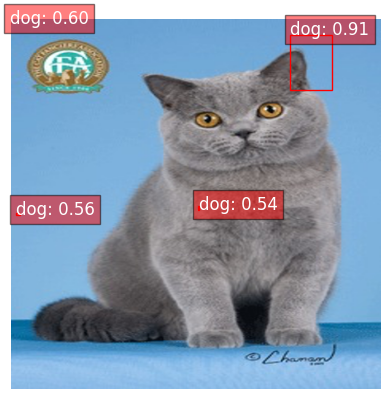

In [8]:
def inference(model, image_path, transform, device, class_to_idx, threshold=0.5):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    original_width, original_height = image.size

    resized_image = image.resize((448, 448))
    resized_width, resized_height = resized_image.size

    transformed_image = transform(resized_image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(transformed_image)
        output = output.view(1, 2, 2, 4 + len(class_to_idx))

    fig, ax = plt.subplots(1)
    ax.axis('off')
    ax.imshow(resized_image)

    for grid_y in range(2):
        for grid_x in range(2):
            class_pred = output[0, grid_y, grid_x, 4:].argmax().item()
            bbox = output[0, grid_y, grid_x, :4].tolist()

            confidence = torch.softmax(output[0, grid_y, grid_x, 4:], dim=0)[class_pred].item()

            x_min = bbox[0] * (resized_width / 2) + grid_x * (resized_width / 2)
            y_min = bbox[1] * (resized_height / 2) + grid_y * (resized_height / 2)
            x_max = bbox[2] * (resized_width / 2) + grid_x * (resized_width / 2)
            y_max = bbox[3] * (resized_height / 2) + grid_y * (resized_height / 2)

            if confidence > threshold:
                rect = patches.Rectangle(
                    (x_min, y_min),
                    x_max - x_min,
                    y_max - y_min,
                    linewidth=1,
                    edgecolor='r',
                    facecolor='none'
                )
                ax.add_patch(rect)
                plt.text(
                    x_min,
                    y_min,
                    f'{list(class_to_idx.keys())[class_pred]}: {confidence:.2f}',
                    color='white',
                    fontsize=12,
                    bbox=dict(facecolor='red', alpha=0.5)
                )
    plt.show()

model.load_state_dict(torch.load('best_model.pth'))

image_path = os.path.join(image_dir, 'Cats_Test0.png')
inference(model, image_path, transform, device, class_to_idx, threshold=0.5)